In [1]:
# Upload the zip file (if not using Drive)
from zipfile import ZipFile
import os

# Unzip the uploaded file
zip_path = '/content/Tom And Jerry.v4i.tensorflow.zip'  # Update if path is different
extract_path = '/content/tom_and_jerry'

with ZipFile(zip_path, 'r') as zip_ref:
    zip_ref.extractall(extract_path)


In [19]:
# Import Libraries
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import (Conv2D, MaxPooling2D, Flatten, Dense, Dropout, Rescaling,
                                     Input, RandomFlip, RandomRotation, RandomZoom, RandomBrightness, RandomContrast)
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.preprocessing import image_dataset_from_directory


In [14]:
# Dataset parameters
dataset_path = extract_path
img_size = (224, 224)
batch_size = 32
seed = 42

# Load full dataset
full_ds = image_dataset_from_directory(
    dataset_path,
    image_size=img_size,
    batch_size=batch_size,
    shuffle=True,
    seed=seed
)

class_names = full_ds.class_names
print("Class names:", class_names)

# Split manually (80% train, 20% test)
ds_size = len(full_ds)
train_size = int(0.8 * ds_size)
train_ds = full_ds.take(train_size)
test_ds = full_ds.skip(train_size)


Found 313 files belonging to 1 classes.
Class names: ['train']


In [15]:
# Define augmentation
data_augmentation = tf.keras.Sequential([
    RandomFlip("horizontal"),
    RandomRotation(0.2),
    RandomZoom(0.2),
    RandomBrightness(0.2),
    RandomContrast(0.2),
])

# Apply augmentation
augmented_train_ds = train_ds.map(lambda x, y: (data_augmentation(x, training=True), y),
                                  num_parallel_calls=tf.data.AUTOTUNE)

# Prefetch for performance
augmented_train_ds = augmented_train_ds.prefetch(tf.data.AUTOTUNE)
test_ds = test_ds.prefetch(tf.data.AUTOTUNE)


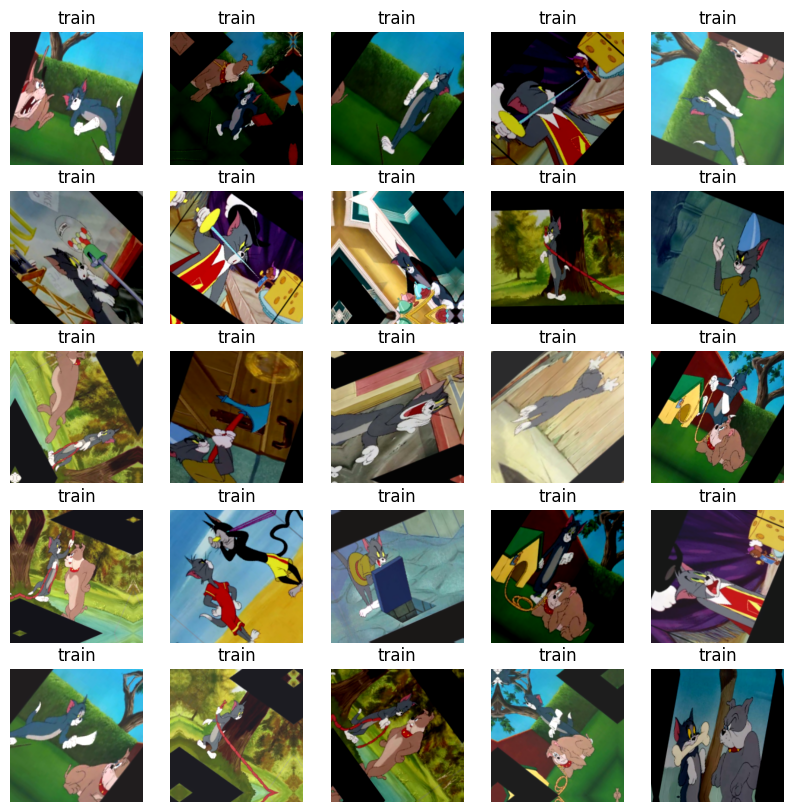

In [16]:
# Show sample images
image_batch, label_batch = next(iter(augmented_train_ds))
plt.figure(figsize=(10, 10))
for i in range(25):
    ax = plt.subplot(5, 5, i + 1)
    plt.imshow(image_batch[i].numpy().astype("uint8"))
    plt.title(class_names[label_batch[i]])
    plt.axis("off")
plt.show()


In [20]:
# Build Custom CNN Model
model = Sequential([
    Input(shape=(img_size[0], img_size[1], 3)),
    Rescaling(1./255),

    Conv2D(32, (3,3), activation='relu'),
    MaxPooling2D(),

    Conv2D(64, (3,3), activation='relu'),
    MaxPooling2D(),

    Flatten(),
    Dense(128, activation='relu'),
    Dropout(0.5),
    Dense(len(class_names), activation='softmax')  # Output layer
])

# Compile
model.compile(optimizer=Adam(learning_rate=0.0001),
              loss='sparse_categorical_crossentropy',
              metrics=['accuracy'])

model.summary()


Model: "sequential_5"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ rescaling_2 (Rescaling)         │ (None, 224, 224, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_4 (Conv2D)               │ (None, 222, 222, 32)   │           896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_4 (MaxPooling2D)  │ (None, 111, 111, 32)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_5 (Conv2D)               │ (None, 109, 109, 64)   │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_5 (MaxPooling2D)  │ (None, 54, 54, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_2 (Flatten)             │ (None, 186624)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_6 (Dense)                 │ (None, 128)            │    23,888,000 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_3 (Dropout)             │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_7 (Dense)                 │ (None, 1)              │           129 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 23,907,521 (91.20 MB)

 Trainable params: 23,907,521 (91.20 MB)

 Non-trainable params: 0 (0.00 B)

In [7]:
# Train and Evaluate CNN
history = model.fit(
    train_data,
    validation_data=val_data,
    epochs=5
)


/usr/local/lib/python3.11/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


Epoch 1/5
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 723ms/step - accuracy: 0.6702 - loss: 0.2726

/usr/local/lib/python3.11/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


8/8 ━━━━━━━━━━━━━━━━━━━━ 10s 850ms/step - accuracy: 0.6931 - loss: 0.2536 - val_accuracy: 1.0000 - val_loss: 6.8917e-16
Epoch 2/5
8/8 ━━━━━━━━━━━━━━━━━━━━ 8s 1s/step - accuracy: 1.0000 - loss: 3.6606e-14 - val_accuracy: 1.0000 - val_loss: 2.0623e-22
Epoch 3/5
8/8 ━━━━━━━━━━━━━━━━━━━━ 6s 781ms/step - accuracy: 1.0000 - loss: 5.0505e-18 - val_accuracy: 1.0000 - val_loss: 7.5928e-26
Epoch 4/5
8/8 ━━━━━━━━━━━━━━━━━━━━ 7s 941ms/step - accuracy: 1.0000 - loss: 3.0927e-16 - val_accuracy: 1.0000 - val_loss: 1.3885e-27
Epoch 5/5
8/8 ━━━━━━━━━━━━━━━━━━━━ 6s 754ms/step - accuracy: 1.0000 - loss: 2.6331e-24 - val_accuracy: 1.0000 - val_loss: 1.9395e-28


In [18]:
#Transfer Learning (VGG16)
from tensorflow.keras.applications import VGG16
from tensorflow.keras.layers import GlobalAveragePooling2D

# Load VGG16 without top layers
base_model = VGG16(weights='imagenet', include_top=False, input_shape=(img_size[0], img_size[1], 3))
base_model.trainable = False  # Freeze base

# Build model on top
vgg_model = Sequential([
    Input(shape=(img_size[0], img_size[1], 3)),
    Rescaling(1./255),
    base_model,
    GlobalAveragePooling2D(),
    Dense(256, activation='relu'),
    Dropout(0.5),
    Dense(len(class_names), activation='softmax')
])

vgg_model.compile(optimizer='adam',
                  loss='sparse_categorical_crossentropy',
                  metrics=['accuracy'])

vgg_model.summary()


58889256/58889256 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step


Model: "sequential_4"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ rescaling_1 (Rescaling)         │ (None, 224, 224, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ vgg16 (Functional)              │ (None, 7, 7, 512)      │    14,714,688 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_average_pooling2d        │ (None, 512)            │             0 │
│ (GlobalAveragePooling2D)        │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_4 (Dense)                 │ (None, 256)            │       131,328 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_2 (Dropout)             │ (None, 256)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_5 (Dense)                 │ (None, 1)              │           257 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 14,846,273 (56.63 MB)

 Trainable params: 131,585 (514.00 KB)

 Non-trainable params: 14,714,688 (56.13 MB)

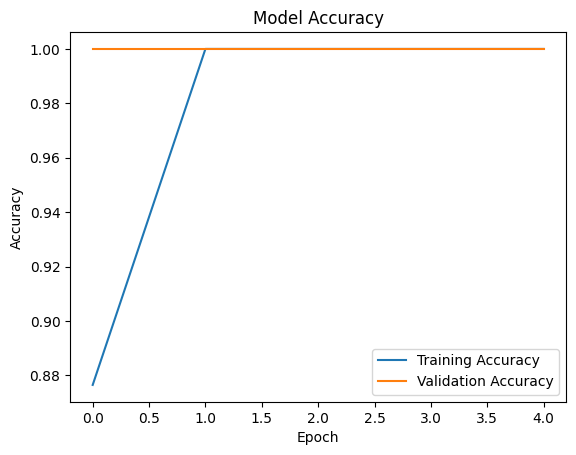

In [8]:
# Plot Accuracy
plt.plot(history.history['accuracy'], label='Training Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.title("Model Accuracy")
plt.xlabel("Epoch")
plt.ylabel("Accuracy")
plt.legend()
plt.show()
